In [2]:
#We'll build a sentiment classifier using the review rating as the sentiment gold standard. 
#Treating this as a binary classification task, we can consider a 1-2 star review as negative, and a 4-5 star review as positive. 
#In order to achieve a roughly balanced data set, you may want to remove some of the positive reviews

In [8]:
import csv, re
from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier
from random import shuffle
from sklearn.pipeline import Pipeline
import time
start_time = time.time()

In [17]:
# We import some of the parsing and loading methods we had from previous tasks
def parse_label(label):
    if label == '__label2__':
        return 'real'
    else:
        return 'fake'    

def parse_verification(label):
    if label == 'N':
        return 0
    else:
        return 1      

def flatten(lst):
    for el in lst:
        if isinstance(el, list):
            yield from el
        else:
            yield el    

# Convert line from input file into an id/text/label tuple
def parseReview(reviewLine):
    # Should return a triple of an integer, a string containing the review, and a string indicating the label
    return (reviewLine[0], \
            reviewLine[8] + ' ' + reviewLine[7], \
            parse_label(reviewLine[1]), \
            reviewLine[2], \
            parse_verification(reviewLine[3]))

# load data from a file and append it to the rawData
def loadData(path, Text=None):
    with open(path) as f:
        reader = csv.reader(f, delimiter='\t')
        next(reader, None)  # skip the headers        
        for line in reader:
            (Id, Text, Label, Rating, Verified) = parseReview(line)
            rawData.append((Id, Text, Label, Rating, Verified))
            
#Loading our set
rawData = []          # the filtered data from the dataset file (should be 21000 samples)
reviewPath = 'amazon_reviews.txt'
loadData(reviewPath) 

REAL vs FAKE F-K Score


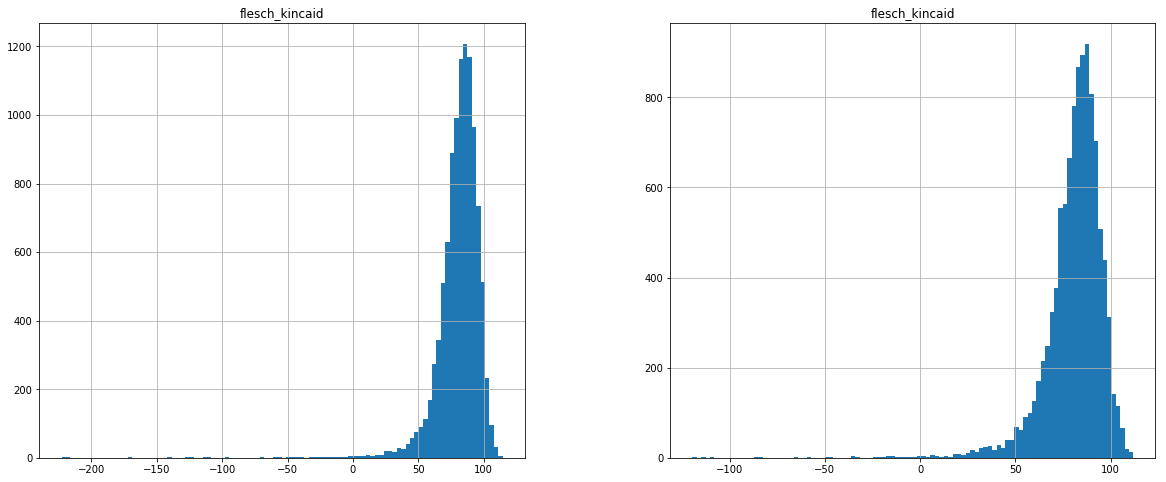

In [20]:
#We'll want to put it all in a dataframe, and add some additional features
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import pyphen
dic = pyphen.Pyphen(lang='en')
stop_words = set(stopwords.words('english'))

def averageLen(lst):
    lengths = [len(i) for i in lst]
    return 0 if len(lengths) == 0 else (float(sum(lengths)) / len(lengths)) 


names = ['doc_id', 'label', 'rating', 'verified_purchase', \
         'pr_category', 'pr_id', 'pr_title', 'review_title', 'review_text']
data = pd.read_csv('amazon_reviews.txt', skiprows=[0], names=names, sep='\t')
data['verified_purchase'] = data['verified_purchase'].apply(lambda x: 1 if x=='Y' else 0)
data['label'] = data['label'].apply(lambda x: 'real' if x=='__label2__' else 'fake')
data['review_text_length'] = data.apply(lambda row: len(row.review_text), axis=1)
data['review_title_length'] = data.apply(lambda row: len(row.review_title), axis=1)
data['tokenized_review'] = data.apply(lambda row: re.sub(r"(\w)([.,;:!-?'\"”\)])", r"\1 \2", row['review_text']), axis=1)
data['tokenized_review'] = data.apply(lambda row: re.sub(r"([.,;:!-?'\"“\(])(\w)", r"\1 \2", row['tokenized_review']), axis=1)
data['tokenized_review'] = data.apply(lambda row: re.sub(r"<[^>]*>", "", row['tokenized_review']), axis=1)
data['tokenized_review'] = data.apply(lambda row: nltk.word_tokenize(row['tokenized_review'].lower()), axis=1)
data['tokenized_review_string'] = data['tokenized_review'].apply(' '.join)
data['tokens'] = data.apply(lambda row: [t for t in row['tokenized_review'] if t.isalpha()], axis=1)
data['tokens'] = data.apply(lambda row: [t for t in row['tokens'] if t not in stop_words], axis=1)
data['stopwords'] = data.apply(lambda row: [t for t in row['tokenized_review'] if t.isalpha()], axis=1)
data['stopwords'] = data.apply(lambda row: [t for t in row['tokenized_review'] if t in stopwords.words('english')], axis=1)
data['num_tokens'] = data.apply(lambda row: len(row['tokens']), axis=1)
data['avg_len_tokens'] = data.apply(lambda row: averageLen(row['tokens']), axis=1)
data['num_stopwords'] = data.apply(lambda row: len(row['stopwords']), axis=1)

#Looking for the Flesch-Kincaid Readability measure across our pipulation
data['word_count'] = data.apply(lambda row: len(row['tokenized_review']), axis=1)
data['sent_count'] = data.apply(lambda row: len(sent_tokenize(row['review_text'])), axis=1)
data['syll_count'] = data.apply(lambda row: len(list(flatten([dic.inserted(text).split('-') for text in row['tokenized_review']]))), axis=1)
data['flesch_kincaid'] = data.apply(lambda row: 206.835 - 1.015*row['word_count']/row['sent_count'] - 84.6*row['syll_count']/row['word_count'], axis=1)

real_data = data[data['label']== 'real'] 
fake_data = data[data['label']== 'fake'] 

fig, axes = plt.subplots(1, 2)
fig.set_size_inches(20,8)

print('REAL vs FAKE F-K Score')
plt.title('Real Reviews')
real_data.hist('flesch_kincaid', bins=100, ax=axes[0])

plt.title('Fake Reviews')
fake_data.hist('flesch_kincaid', bins=100, ax=axes[1])

plt.show()

In [23]:
#Finally on to our classifier, the first thing is to add a column that will serve to capture the sentiment
def get_sent(rating):
    if rating < 3:
        sent = 'negative'
    elif rating > 3:
        sent = 'positive'
    else:
        sent = 'mweh'
    return sent

data['sentiment'] = data.apply(lambda row: get_sent(row['rating']), axis=1)

In [78]:
#Now let's make some vectors from our data, these will be used by the classifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data['review_text'], data['sentiment'], test_size=0.33, random_state=1)

# Initialize a CountVectorizer and Tfidf objects
count_vectorizer = CountVectorizer(stop_words='english')
tfidf_vectorizer = TfidfVectorizer(stop_words="english", max_df=0.7)

# Transform the training data using only the 'text' column values: count_train 
count_train = count_vectorizer.fit_transform(X_train)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data using only the 'review_text' column values: count_test 
count_test = count_vectorizer.transform(X_test)
tfidf_test = tfidf_vectorizer.transform(X_test)

In [79]:
# Import the necessary modules for our classifier
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB

nb_classifier = MultinomialNB()
nb_classifier.fit(count_train, y_train)
pred = nb_classifier.predict(count_test)

score = metrics.accuracy_score(y_test, pred)
print('Classifier accuracy: ' + str(round(100*score, 2)) + '%')

cm = metrics.confusion_matrix(y_test, pred, labels=['negative', 'mweh', 'positive'])
print('Confusion matrix:')
print(cm)


Classifier accuracy: 81.2%
Confusion matrix:
[[ 330   11  600]
 [  56    9  523]
 [  87   26 5288]]


In [69]:
# What if we used to Tfidf vectors instead?
nb_classifier = MultinomialNB()
nb_classifier.fit(tfidf_train, y_train)
pred = nb_classifier.predict(tfidf_test)

score = metrics.accuracy_score(y_test, pred)
print('Classifier accuracy: ' + str(round(100*score, 2)) + '%')

cm = metrics.confusion_matrix(y_test, pred, labels=['negative', 'mweh', 'positive'])
print('Confusion matrix:')
print(cm)


Classifier accuracy: 77.94%
Confusion matrix:
[[   0    0  941]
 [   0    0  588]
 [   0    0 5401]]


In [ ]:
# Create the list of alphas: alphas
import numpy as np
alphas = np.arange(0, 1.5, .1)

def train_and_predict(alpha):
    nb_classifier = MultinomialNB(alpha=alpha)
    nb_classifier.fit(tfidf_train, y_train)
    pred = nb_classifier.predict(tfidf_test)
    score = metrics.accuracy_score(y_test, pred)
    return score

for alpha in alphas:
    print('Alpha: ' + str(alpha) + ' score: ' + str(round(train_and_predict(alpha), 3)))

In [ ]:
alphas = np.arange(0, 1.5, .1)

def train_and_predict(alpha):
    nb_classifier = MultinomialNB(alpha=alpha)
    nb_classifier.fit(count_train, y_train)
    pred = nb_classifier.predict(count_test)
    score = metrics.accuracy_score(y_test, pred)
    return score

for alpha in alphas:
    print('Alpha: ' + str(alpha) + ' score: ' + str(round(train_and_predict(alpha), 3)))

In [80]:
#But we can also play with vectorizing ngrams instead of just unigrams


print('Unigrams only:')
count_vectorizer = CountVectorizer(stop_words='english')
count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)
nb_classifier = MultinomialNB()
nb_classifier.fit(count_train, y_train)
pred = nb_classifier.predict(count_test)
score = metrics.accuracy_score(y_test, pred)
print('Classifier accuracy: ' + str(round(100*score, 2)) + '%')
cm = metrics.confusion_matrix(y_test, pred, labels=['negative', 'mweh', 'positive'])
print('Confusion matrix:')
print(cm)

print('Ngrams:')
count_vectorizer = CountVectorizer(ngram_range=(1, 7), analyzer='char')
count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)
nb_classifier = MultinomialNB(alpha=0.2)
nb_classifier.fit(count_train, y_train)
pred = nb_classifier.predict(count_test)
score = metrics.accuracy_score(y_test, pred)
print('Classifier accuracy: ' + str(round(100*score, 2)) + '%')
cm = metrics.confusion_matrix(y_test, pred, labels=['negative', 'mweh', 'positive'])
print('Confusion matrix:')
print(cm)

Unigrams only:
Classifier accuracy: 81.2%
Confusion matrix:
[[ 330   11  600]
 [  56    9  523]
 [  87   26 5288]]
Ngrams:
Classifier accuracy: 84.14%
Confusion matrix:
[[ 531   45  365]
 [ 111   42  435]
 [ 105   38 5258]]


In [99]:
# count_vectorizer = CountVectorizer(stop_words='english')
# count_train = count_vectorizer.fit_transform(X_train)
# count_train.shape

In [98]:
# df.apply(LabelEncoder().fit_transform)